In [1]:
import numpy as np
import IO
import SVD
from matplotlib import pyplot as plt
import time
import tools
import Wannier2Bloch

In [2]:
alat = 10.26
#FCC SILICON
outdir = "./Plots_cb/"
DataDir = "../../DATA_cb/"
prefix = "silicon"
at = (alat / 2.0) * np.array([[-1., 0., 1.], [0., 1., 1.], [-1., 1., 0.]]).T
k_mesh = [6,6,6]
G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
X = np.array([0.5, 0.0, 0.5])
K = np.array([0.375, 0.3750, 0.75])
W = np.array([ 0.5000000000,0.2500000000,0.7500000000])
path1 = np.array([[L,G],[G,X],[X,K],[K,G]])
xticks_labels1 = ['L',r"$\Gamma$",'X','K','G']
path2 = np.array([[L,G],[G,K]])
xticks_labels2 = ['L',r"$\Gamma$",'K']

### Import Hamiltonian and Dynamical Matrix
  - Generate R vectors
  - Sort Data structures

Reading Text Data: ../../DATA_cb/epwdata.fmt
Dims: Bands=10, Modes=6, R_k=279, R_g=279, R_q=279
!All the file has been red!
Replicating wigner.f90 scan loops...

Total vectors found: 279 (Should be 279)


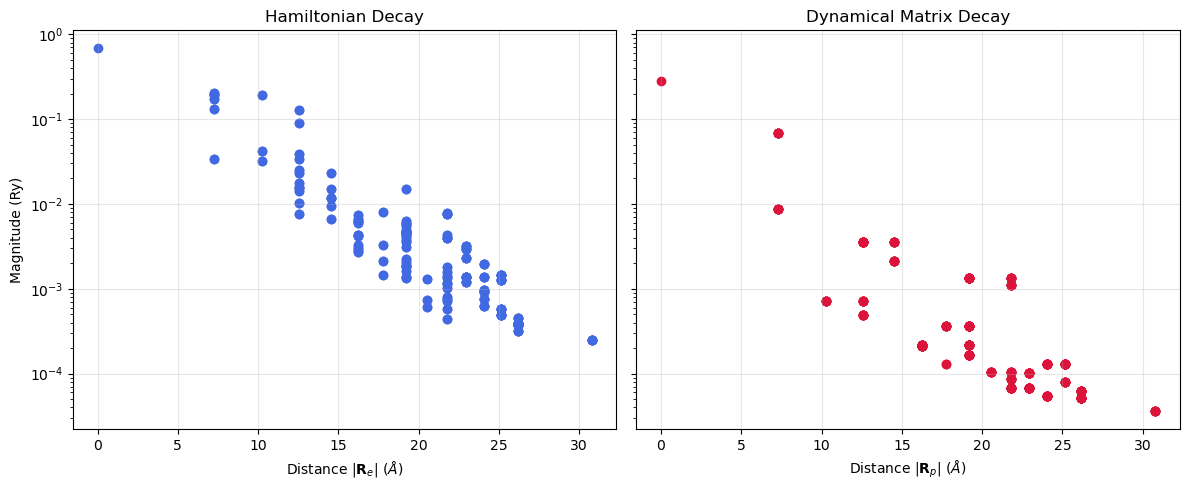

In [3]:
file_fmt = DataDir + "epwdata.fmt"
H_sort, D_sort,R_sort ,R, ef ,nbnd, nrr_k, nmodes, nrr_q, nrr_g = IO.read_epwdata_fmt(file_fmt, at,k_mesh,True,outdir)

### Import el-ph matrix in Wannier space
    -plot Decay
    -Sort by distance
    - Match VASP shape

Reading ../../DATA_cb/silicon.epmatwp...
G shape loaded: (279, 279, 6, 10, 10)


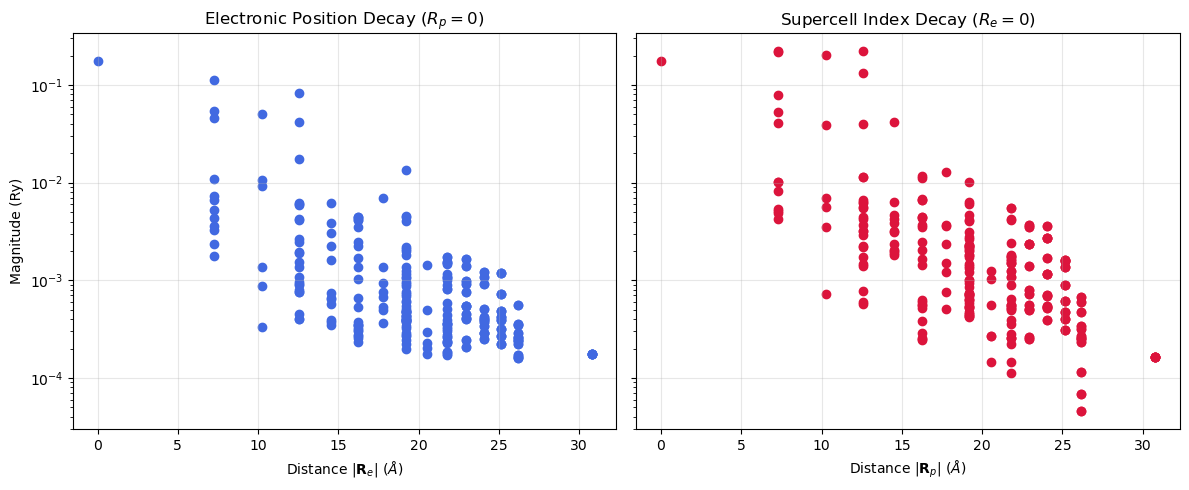

In [4]:
file_epmatwp = DataDir + prefix +  ".epmatwp"
G =  IO.read_epmatwp(file_epmatwp,nbnd, nrr_k, nmodes, nrr_g,R,PLOT=True,outdir = outdir)

### Obtain SVD decomposition

In [6]:
#Wannier
rel_error, x_percent = SVD.svd_trend(G,nbnd,nbnd,nmodes)
U,s,Vt = SVD.SVD(G,nbnd,nbnd,nmodes)


Number of SVs: 279


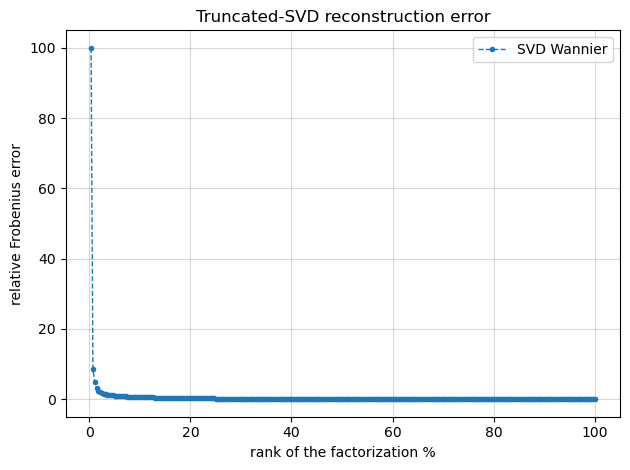

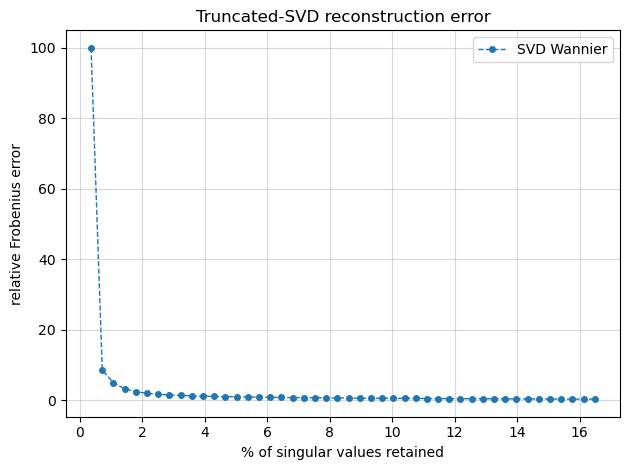

In [7]:
#Full Trend
fig = plt.figure()
rank_percent = np.arange(1, x_percent.size + 1) / x_percent.size * 100
plt.plot(rank_percent[:], rel_error*100,linestyle="--", marker = "o", markersize = 3,linewidth=1, label="SVD Wannier")
plt.xlabel("rank of the factorization %")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.grid(alpha=0.5)
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.show()
fig.savefig(outdir+"SVD_trend.jpg")


#ZOOM
fig = plt.figure()
plt.plot(rank_percent[0:46], rel_error[0:46]*100,linestyle="--", marker = "o", markersize = 4,linewidth=1, label="SVD Wannier")
plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()
fig.savefig(outdir+"SVD_zoom.jpg")



### Electron Band Interpolation

$H^{\mathrm{el}}_{mn}(\mathbf{k}')=\sum_{i,j}U_{m i}(\mathbf{k}')(\frac{1}{N_e}\sum_{\mathbf{R}_e} e^{i\mathbf{k}'\cdot\mathbf{R}_e})H_{ij}(\mathbf{R}_e)U^{\dagger}(\mathbf{k}')_{j n}$

#### Where by defintion we must have:
The new wannier matrices rotate the wannier WF to Bloch at new k point, and they must be ortghogonal
$  H^{\mathrm{el}}_{mn}(\mathbf{k}')= \delta_{mn}\epsilon _ n(\mathbf{k}')$




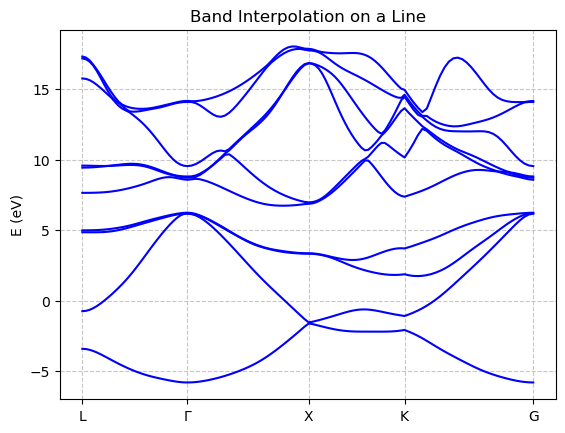

../../DFT/bands/


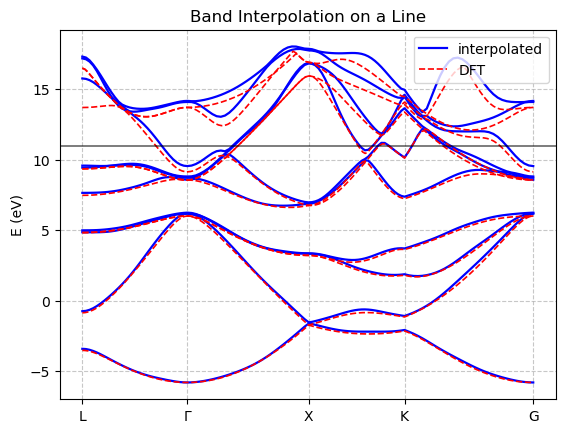

In [ ]:
import py4vasp 
b_lat = tools.get_reciprocal_lattice(at)
q_cart1, x_axis1, xticks1 = tools.build_path_and_ticks(b_lat,path1,30)
q_cart2, x_axis2, xticks2 = tools.build_path_and_ticks(b_lat,path2,30)

E1,_ = Wannier2Bloch.interpolate_H(H_sort,q_cart1,R_sort)
Wannier2Bloch.plotBands(x_axis1,nbnd,E1,xticks1,xticks_labels1,outdir)

DFT_DIR="../../DFT/bands/"


# Plot with VASP output data
def plotBands_comparded(x_axis,nbands,evals,xticks_positions,xticks_labels,vaspdir="",outdir=""):
    n_vb = 4
    n_cb = nbands - n_vb
    print(vaspdir)
    if vaspdir!="":
        calc = py4vasp.Calculation.from_path(vaspdir)
        d = calc.band.to_dict()
        bands = np.array(d["bands"])          # (nk, nb) or (spin, nk, nb)
        occ   = np.array(d["occupations"])
        x     = np.array(d["kpoint_distances"])
        x *= (max(x_axis))/max(x) #rescale x
        #bands += (bands[0,0]) - (evals[0,0])
        # ---- gestisci spin automaticamente ----
        if bands.ndim == 3:   # spin-polarized
            bands = bands[0]  # prendi spin-up (per Si/LiF non cambia)
            occ   = occ[0]
        # ---- identifica bande di valenza ----
        # una banda è "valence" se è occupata (occ ~ 1) in ALMENO un k-point
        is_valence = np.any(occ > 0.5, axis=0)

        valence_band_indices = np.where(is_valence)[0]
        # ---- ordina le bande di valenza per energia massima (VBM) ----
        vbm_energy_per_band = bands[:, valence_band_indices].max(axis=0)
        order = np.argsort(vbm_energy_per_band)
        top_vb = valence_band_indices[order][-n_vb:]
        idx = [0, 40, 80, 120, 159]
        xticks = [x[i] for i in idx]
        
    fig = plt.figure()
    ax = fig.gca()

    ax.plot(x_axis, evals[:, 0],color="Blue",lw=1.6,label="interpolated")
    for i in range(1,nbands):
        ax.plot(x_axis, evals[:, i],color="Blue",lw=1.6)
        

    if vaspdir!="":
        shift = np.min(evals[:,0]) - np.min(bands[:,top_vb[0]]) #shift to match energy def
        ax.plot(x, bands[:, top_vb[0]] + shift, color="red", lw=1.2, linestyle="--",label="DFT")
        for b in top_vb[1:]:
            ax.plot(x, bands[:, b] + shift, color="red", lw=1.2, linestyle="--")
        for b in range(top_vb[-1]+1, top_vb[-1]+n_cb+1):
            ax.plot(x, bands[:, b] + shift, color="red", lw=1.2, linestyle="--")
    
    ax.axhline(11, color="black", lw=1.2, linestyle="-",alpha=0.6)
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title("Disentanglement (frozen window up to 11 ev)")
    plt.ylabel("E (eV)")
    plt.legend()
    plt.show()
    fig.savefig(outdir+"Bands_compared.jpg")

plotBands_comparded(x_axis1,nbnd,E1,xticks1,xticks_labels1,DFT_DIR,outdir)
